# Deepdive notebook converted to plot proper figures

In [2]:
# from env_figs import Environment
# from emv_lite import build_and_run
from model import NN
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
total_returns = np.load("multi_syll_robust.npy")

In [4]:
total_returns.shape
params_path = "params.json"
with open(params_path, "r") as f:
    parameters = json.load(f)

In [5]:
np.mean(total_returns[:, 0, :], axis=0).mean()

0.9206885416129933

In [6]:
total_returns.shape

(100, 2, 4)

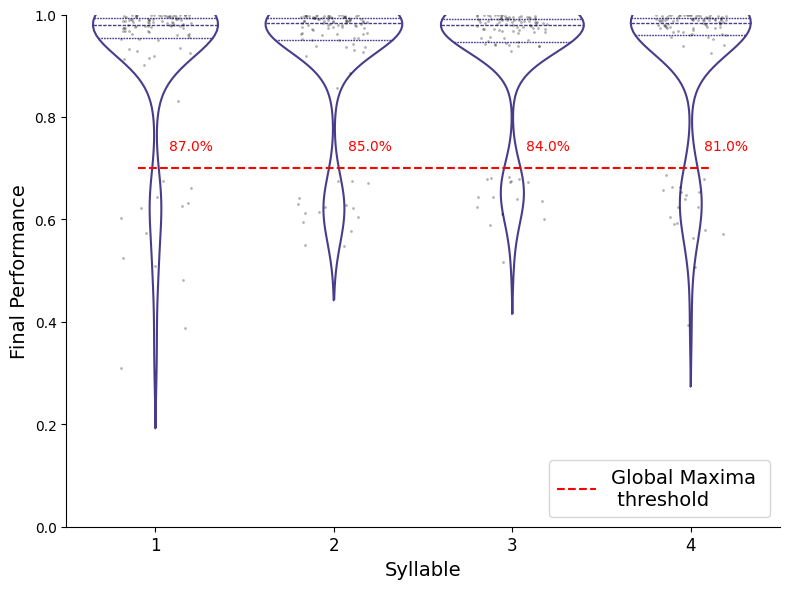

In [7]:
def plot_results_violin(returns_no_cut, params, label, xlabels=None):
    # Extract returns for the first group (i.e., [:, 0, :])
    returns_no_cut = returns_no_cut[:, 0, :]  # Now shape is (25, 4), 25 returns for 4 syllables

    sorted_params = np.arange(params)
    sorted_indices = np.argsort(sorted_params)
    
    returns_no_cut = returns_no_cut[:, sorted_indices]  # Sorting according to the params
    sorted_params = sorted_params[sorted_indices]

    n_values = len(sorted_params)
    above_threshold2 = np.zeros(n_values)
    
    # Flatten data for seaborn
    data2 = []
    labels = []

    for i in range(n_values):
        col2 = returns_no_cut[:, i]
        above_threshold2[i] = np.sum(col2 > 0.7) / len(col2)

        # Prepare data for plotting
        data2.extend(col2)
        labels.extend([sorted_params[i]] * len(col2))

    # Plotting
    plt.figure(figsize=(2 * n_values, 6))

    # Plot the violin plot
    ax = sns.violinplot(x=labels, y=data2, inner='quartile', color='darkslateblue', fill=False, alpha=1, split=False, inner_kws={'linewidth': 1, 'color': 'darkslateblue', 'alpha': 1})  

    # Overlay strip plot for raw data points
    sns.stripplot(x=labels, y=data2, size=2, color='black', alpha=0.3, jitter=0.2)

    # Add threshold line and annotations
    for i in range(n_values):
        plt.text(i + 0.2, 0.73, f"{100 * above_threshold2[i]:.1f}%", ha='center', va='bottom', fontsize=10, color='red')
    plt.axhline(0.7, 0.1, 0.9, color='red', linestyle='--', label='Global Maxima \n threshold')

    # Labeling and axis formatting
    plt.xlabel(label, fontsize=14)
    plt.ylabel('Final Performance', fontsize=14)
    plt.ylim(0, 1)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Set xlabels
    if xlabels is not None:
        plt.xticks(ticks=range(n_values), labels=xlabels, fontsize=12)
    # plt.text(1, -0.05, "Final Performance", ha='center', va='center', fontsize=16, fontweight='bold')  
    # Add legend and layout
    plt.legend(loc = 'lower right', fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage
plot_results_violin(total_returns, 4, "Syllable", xlabels=["1", "2", "3", "4"])


C:\Users\Dell\AppData\Local\Temp\ipykernel_21336\3005502481.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


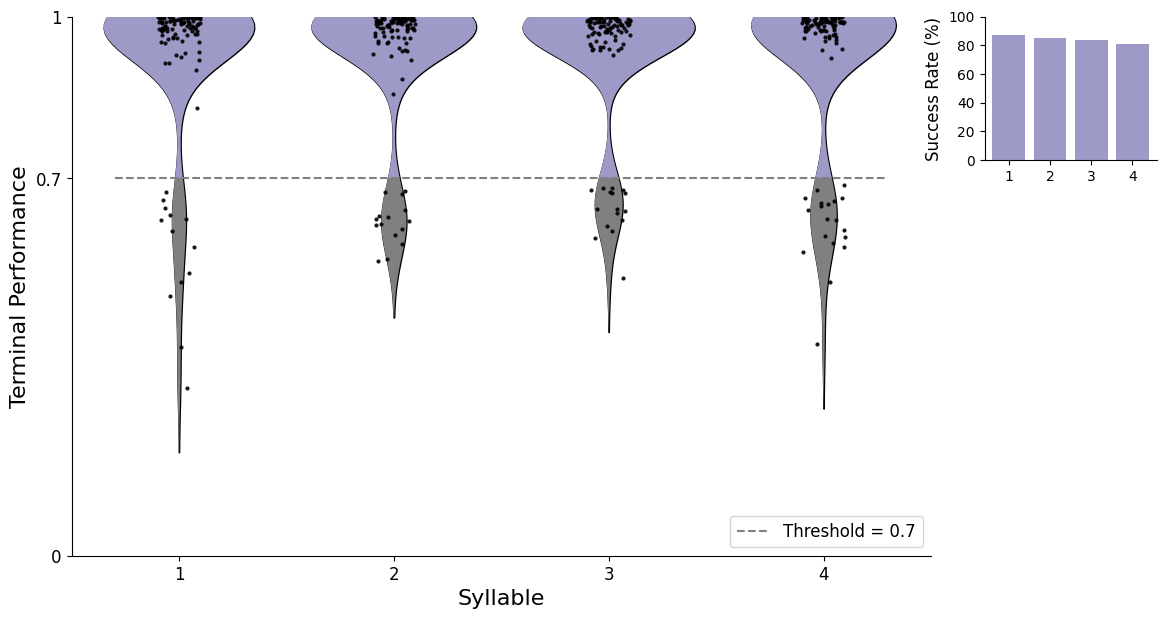

In [17]:

import matplotlib.patches as mpatches

purples_last = plt.cm.Purples(0.5)

def plot_results_violin_single(returns, params, label, xlabels=None, threshold=0.7):
    returns = np.array(returns)
    sorted_indices = np.argsort(params)
    sorted_params = np.array(params)[sorted_indices]
    returns = returns[:, sorted_indices]  # shape: runs Ã— param values

    n_values = len(sorted_params)
    success_rate = np.zeros(n_values)

    data = []
    labels_list = []

    for i in range(n_values):
        col = returns[:, i]
        success_rate[i] = np.sum(col > threshold) / len(col)
        data.extend(col)
        labels_list.extend([sorted_params[i]] * len(col))

    # Create figure with custom layout
    fig = plt.figure(figsize=(3 * n_values + 2, 7))
    gs = fig.add_gridspec(2, 2, width_ratios=[6, 1.2], height_ratios=[2, 5],
                          wspace=0.2 - 0.12*n_values/5, hspace=0.15)

    # Left violin plot
    ax1 = fig.add_subplot(gs[:, 0])
    parts = sns.violinplot(x=labels_list, y=data, inner=None, color='none', linewidth=1, ax=ax1)
    sns.stripplot(x=labels_list, y=data, size=3, color='black', alpha=0.9, jitter=0.1, ax=ax1)

    ax1.axhline(threshold, 0.05, 0.95, color='grey', linestyle='--', label=f'Threshold = {threshold}')

    # Color below and above threshold
    for i, pc in enumerate(parts.collections):
        path = pc.get_paths()[0]
        r_low = mpatches.Rectangle((i-0.4, 0), width=0.8, height=threshold, facecolor='grey', alpha=1)
        r_low.set_clip_path(path, transform=ax1.transData)
        ax1.add_patch(r_low)

        r_high = mpatches.Rectangle((i-0.4, threshold), width=0.8, height=1-threshold, facecolor=purples_last, alpha=1)
        r_high.set_clip_path(path, transform=ax1.transData)
        ax1.add_patch(r_high)

    ax1.set_xlabel(label, fontsize=16)
    ax1.set_ylabel('Terminal Performance', fontsize=16)
    ax1.set_ylim(0, 1)
    ax1.set_yticks([0, threshold, 1])
    ax1.set_yticklabels(['0', f'{threshold}', '1'], fontsize=12)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    if xlabels is not None:
        ax1.set_xticks(range(n_values))
        ax1.set_xticklabels(xlabels, fontsize=12)
    else:
        ax1.set_xticklabels(sorted_params, fontsize=12)

    ax1.legend(loc='lower right', fontsize=12)

    # Success rate bar plot
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.bar(range(n_values), success_rate * 100, color=purples_last, alpha=1)
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Success Rate (%)', fontsize=12)
    ax2.set_xticks(range(n_values))
    ax2.set_xticklabels(sorted_params, rotation=0, ha='center', fontsize=10)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


# Example usage with total_returns data
plot_results_violin_single(total_returns[:, 0, :], [1, 2, 3, 4], "Syllable", xlabels=["1", "2", "3", "4"])

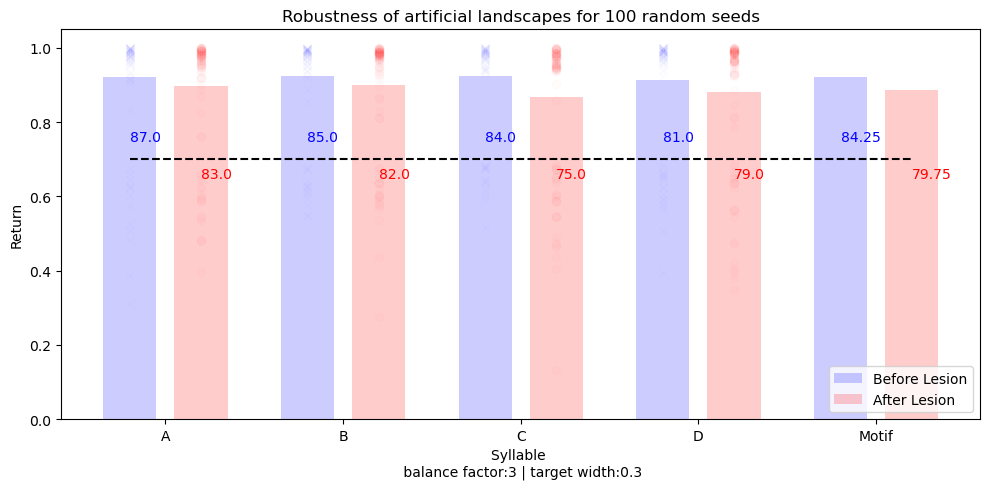

In [7]:
width = 0.2
plt.figure(figsize=(10, 5))
# above 0.7 count as success total count
success_before = np.zeros(4)
success_after = np.zeros(4)
for i in range(4):  
    success_before[i] = len(np.where(total_returns[:, 0, i] > 0.7)[0])/total_returns.shape[0]*100
    success_after[i] = len(np.where(total_returns[:, 1, i] > 0.7)[0])/total_returns.shape[0]*100    
    plt.text(i-width, 0.75, str(success_before[i]), color='b')
    plt.text(i+width, 0.65, str(success_after[i]), color='r')
plt.text(4-width, 0.75, str(success_before.mean()), color='b')
plt.text(4+width, 0.65, str(success_after.mean()), color='r')
plt.hlines(0.7, 0-width, 4+width, color='k', linestyles='--')
for i in range(4):
    plt.plot(i*np.ones_like(total_returns[:, 0, i])-width, total_returns[:, 0, i], 'x', alpha = 0.01, color='b')
    plt.plot(i*np.ones_like(total_returns[:, 1, i])+width, total_returns[:, 1, i], 'o', alpha = 0.01, color='r')
plt.bar(np.arange(4)-width, np.mean(total_returns[:, 0, :], axis=0), color='b', alpha=0.2, width=0.3, label='Before Lesion')
plt.bar(4-width, np.mean(total_returns[:, 0, :], axis=0).mean(), color='b', alpha=0.2, width=0.3)
plt.bar(4+width, np.mean(total_returns[:, 1, :], axis=0).mean(), color='r', alpha=0.2, width=0.3)
plt.bar(np.arange(4)+width, np.mean(total_returns[:, 1, :], axis=0), color='r', alpha=0.2, width=0.3, label='After Lesion')   
plt.xticks(np.arange(5), ['A', 'B', 'C', 'D','Motif'])  
plt.ylabel('Return')    
plt.xlabel(f'Syllable \n balance factor:{parameters['params']['balance_factor']} | target width:{parameters['params']['TARGET_WIDTH']}')
plt.legend(loc="lower right")
plt.title(f'Robustness of artificial landscapes for {total_returns.shape[0]} random seeds')
plt.tight_layout()
plt.show()